## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

## Step 2: Load and Clean the Dataset

In [5]:
# Load CSV
df = pd.read_csv("C:\\Users\\HP\\Downloads\\archive (2)\\Ecommerce_Consumer_Behavior_Analysis_Data.csv")


In [7]:
df.head()

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,...,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,$333.80,...,7,NaN,Tablet,Credit Card,3/1/2024,True,False,Need-based,No Preference,2
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,$222.22,...,5,High,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,$426.22,...,7,Low,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,$101.31,...,1,NaN,Smartphone,Other,10/4/2024,True,True,Need-based,Express,10
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,$211.70,...,10,NaN,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4


In [9]:
# Clean 'Purchase_Amount'
df['Purchase_Amount'] = df['Purchase_Amount'].replace('[\$,]', '', regex=True).astype(float)


<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\HP\AppData\Local\Temp\ipykernel_16620\3145235575.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['Purchase_Amount'] = df['Purchase_Amount'].replace('[\$,]', '', regex=True).astype(float)


In [11]:
# Clean 'Engagement_with_Ads'
df['Engagement_with_Ads'].replace('None', np.nan, inplace=True)
df['Engagement_with_Ads'].fillna(df['Engagement_with_Ads'].mode()[0], inplace=True)

# Convert 'Time_of_Purchase' to datetime
df['Time_of_Purchase'] = pd.to_datetime(df['Time_of_Purchase'], errors='coerce')

C:\Users\HP\AppData\Local\Temp\ipykernel_16620\2747408681.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Engagement_with_Ads'].replace('None', np.nan, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_16620\2747408681.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [13]:
# Drop any remaining nulls 
df.dropna(inplace=True)

## Step 3: RFM (Recency, Frequency, Monetary) Analysis

##  Step 3.1: Create RFM Table

In [19]:
# Set a reference date for recency calculation (e.g., max date in dataset + 1 day)
snapshot_date = df['Time_of_Purchase'].max() + pd.Timedelta(days=1)

# Group data by Customer_ID
rfm = df.groupby('Customer_ID').agg({
    'Time_of_Purchase': lambda x: (snapshot_date - x.max()).days,
    'Customer_ID': 'count',
    'Purchase_Amount': 'sum'
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display head
print(rfm.head())


             Recency  Frequency  Monetary
Customer_ID                              
00-149-4481      331          1    464.76
00-264-3797      258          1    128.01
00-275-9990      186          1    302.74
00-285-9607      217          1    491.49
00-335-5034      141          1    411.40


## Step 4: RFM Segmentation with Scoring

In [22]:
# Score each metric from 1–4
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

# Combine scores into a single RFM score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

# Display top customers
rfm.sort_values('RFM_Score', ascending=False).head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
Customer_ID,,,,,,,
82-304-6495,93,1,459.39,4,4,4,12
91-603-1565,48,1,481.21,4,4,4,12
96-140-1936,3,1,477.35,4,4,4,12
94-746-2001,43,1,489.10,4,4,4,12
93-093-0556,106,1,454.36,4,4,4,12


## Step 5: Customer Segmentation via Clustering

## Step 5.1: Normalize & Apply KMeans

In [26]:
# Normalize RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Review segment distribution
print(rfm['Cluster'].value_counts())


Cluster
0    197
2    192
3    184
1    180
Name: count, dtype: int64


##  Step 6: Visualize Clusters

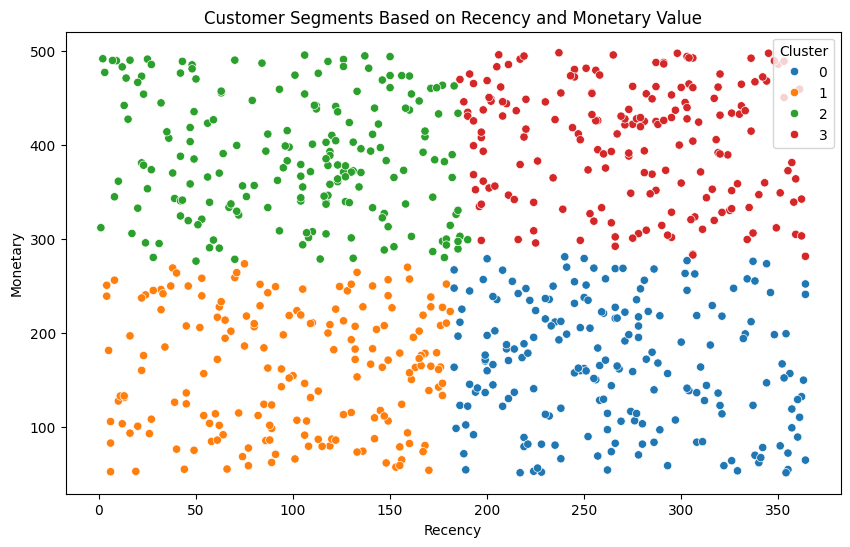

In [29]:
# Add cluster labels to visualization
plt.figure(figsize=(10,6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='tab10')
plt.title('Customer Segments Based on Recency and Monetary Value')
plt.show()


## Step6.1. Heatmap of Average RFM Metrics per Cluster

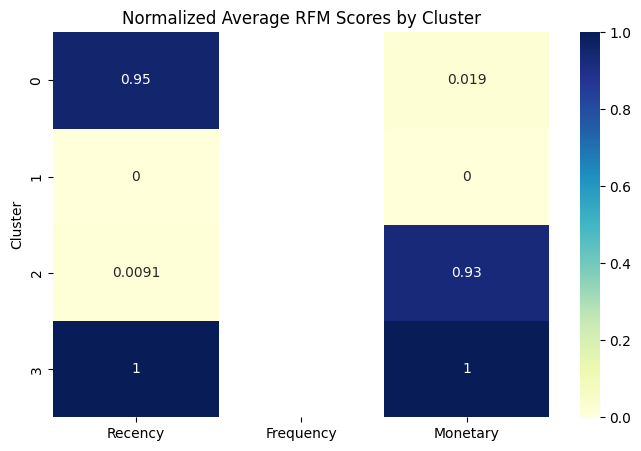

In [37]:
# Calculate average RFM values per cluster
rfm_cluster_avg = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

# Normalize the values (optional, for better heatmap contrast)
rfm_normalized = (rfm_cluster_avg - rfm_cluster_avg.min()) / (rfm_cluster_avg.max() - rfm_cluster_avg.min())

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(rfm_normalized, annot=True, cmap="YlGnBu")
plt.title('Normalized Average RFM Scores by Cluster')
plt.show()

## Step6.2. Histograms for Recency, Frequency, and Monetary

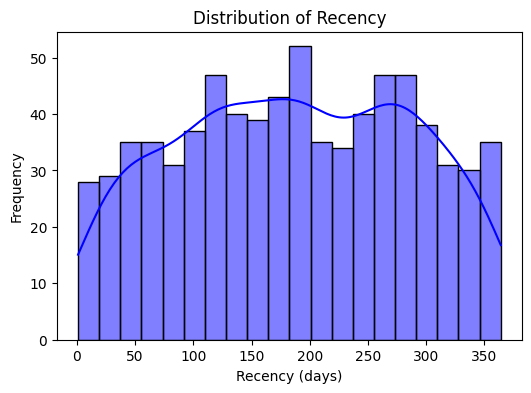

In [40]:
# Recency Histogram
plt.figure(figsize=(6, 4))
sns.histplot(rfm['Recency'], bins=20, kde=True, color='blue')
plt.title('Distribution of Recency')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.show()

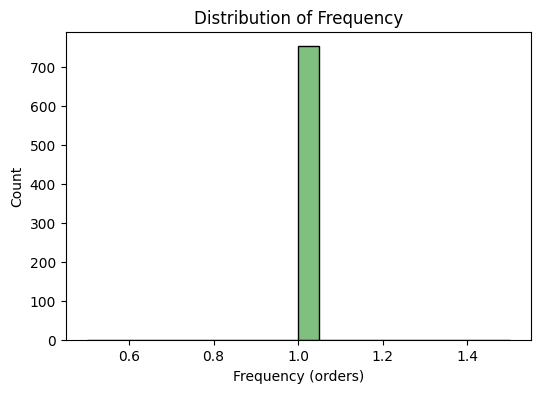

In [42]:
# Frequency Histogram
plt.figure(figsize=(6, 4))
sns.histplot(rfm['Frequency'], bins=20, kde=True, color='green')
plt.title('Distribution of Frequency')
plt.xlabel('Frequency (orders)')
plt.ylabel('Count')
plt.show()

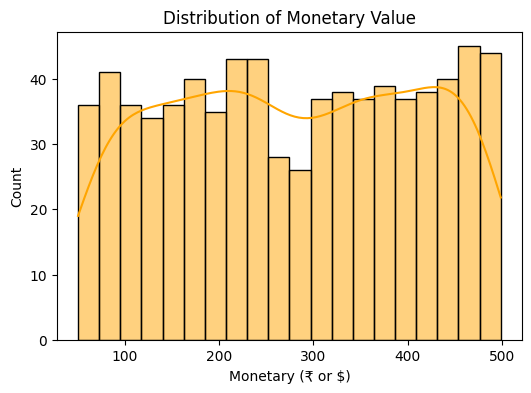

In [44]:
# Monetary Histogram
plt.figure(figsize=(6, 4))
sns.histplot(rfm['Monetary'], bins=20, kde=True, color='orange')
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary (₹ or $)')
plt.ylabel('Count')
plt.show()

## Step 7: Generate Cluster-Level Insights (Summary Stats)

In [34]:
# Create summary without referencing 'Customer_ID' column directly
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'RFM_Score': 'mean'
})

# Add customer count per cluster
cluster_summary['Customer_Count'] = rfm['Cluster'].value_counts()

# Round for clarity
cluster_summary = cluster_summary.round(2)

# Display summary
print(cluster_summary)



        Recency        Frequency        Monetary         RFM_Score  \
           mean median      mean median     mean  median      mean   
Cluster                                                              
0        266.34  262.0       1.0    1.0   166.00  165.01      5.63   
1         99.30  101.5       1.0    1.0   161.49  163.27      7.51   
2        100.95  110.0       1.0    1.0   386.66  381.62      9.35   
3        274.39  279.0       1.0    1.0   402.96  417.74      7.59   

        Customer_Count  
                        
Cluster                 
0                  197  
1                  180  
2                  192  
3                  184  
